In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0
!nvcc --version
!pip install thundersvm

In [ ]:
# import training dataset and test dataset
from google.colab import drive
import pandas as pd

drive.mount('/content/drive/')
training_dataset = pd.read_csv('/content/drive/MyDrive/Euploidy_Prediction/training_dataset.csv', nrows = 182)
test_dataset = pd.read_csv('/content/drive/MyDrive/Euploidy_Prediction/test_dataset.csv', nrows = 46)
embryo_para = ['Embryo Diameter', 'TE Cell Number', 'TE Cell Density', 'TE Cell Size Variance', 'ICM Area']

X_train = training_dataset[embryo_para]
y_train = training_dataset['Binary PGT-A']
X_test = test_dataset[embryo_para]
y_test = test_dataset['Binary PGT-A']

# set random seed
seed = 25

In [ ]:
# k-fold cross-validation for hyperparameters selection
from thundersvm import SVC
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

# create a default SVM classifier
model = SVC(random_state=seed, n_jobs=-1)

# create the grid search parameter grid and scoring funcitons
param_grid = [ {'C':[1, 5, 10, 20, 30], 'kernel':['linear']},
               {'C':[1, 10, 50, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.5, 0.7, 0.9]},
               #{'C':[1, 10, 30], 'kernel':['polynomial'], 'degree': [2,3,4]},
              ]
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score)
}

# create the k-fold object
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
# create the grid search object
n_iter=20
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True,
    n_iter=n_iter,
    refit="AUC",
    verbose=10,
)

# fit grid search
best_model = grid.fit(X_train,y_train)

# print searching results
print(f'Best AUC score: {best_model.best_score_}')
print(f'Best model parameters: {best_model.best_params_}')

In [ ]:
# model training with the 'best' hyperparameters and model test by the test dataset
from thundersvm import SVC
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix

# build the 'best' SVM classifier
best_model = SVC(C=5, kernel='linear', random_state=seed, n_jobs=-1)

# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]

# fit the model
best_model.fit(X_train, y_train)

# final model assessment
pred_train = best_model.predict(X_train)
pred_test = best_model.predict(X_test)
pred_test = best_model.decision_function(X_test) > 0.95

print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))
tn, fp, fn, tp = confusion_matrix(y_test,pred_test).ravel()
print(confusion_matrix(y_test,pred_test))  # 11-TN; 12-FP; 21-FN; 22-TP

Train Accuracy:  0.8176795580110497
Test Accuraccy:  0.8
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        19
           1       0.87      0.77      0.82        26

    accuracy                           0.80        45
   macro avg       0.80      0.81      0.80        45
weighted avg       0.81      0.80      0.80        45

[[16  3]
 [ 6 20]]


Embryo Diameter -0.0399354678580293
TE Cell Number 0.22891536361379988
TE Cell Density -0.01586001489203275
TE Cell Size Variance 0.06917349218168285
ICM Area -0.004020848845867464


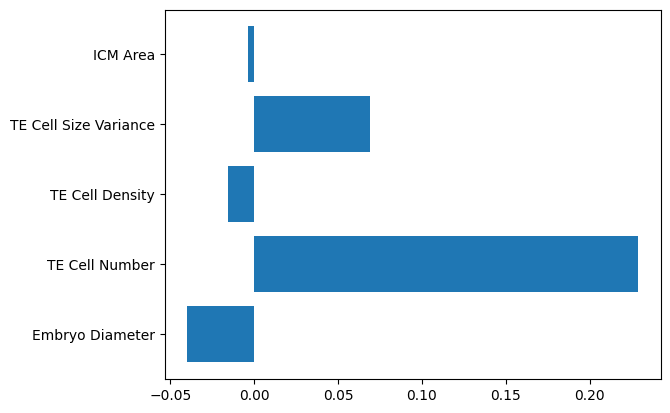

In [ ]:
# calculate feature importance
from matplotlib import pyplot
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, X_train, y_train, n_repeats=5, scoring='roc_auc', random_state=seed)
importance = result.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
	print(embryo_para[i], v)

# plot feature importance
pyplot.barh([x for x in range(len(importance))], importance)
pyplot.yticks([x for x in range(len(importance))], embryo_para)
pyplot.show()

roc_auc_score:  0.8805668016194332


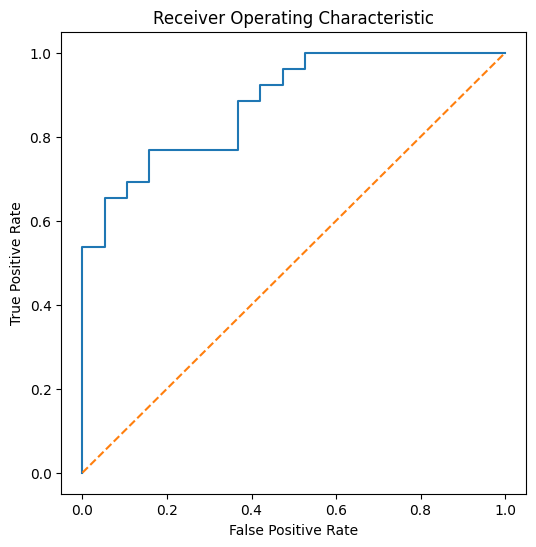

In [ ]:
# plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# calculate AUC
y_score = best_model.decision_function(X_test)
print('roc_auc_score: ', roc_auc_score(y_test, y_score))

# calculate FPR, TPR and threshold
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
FPRTPR_df2 = pd.DataFrame({'FPR': false_positive_rate, 'TPR': true_positive_rate, 'THR': threshold})

# plot
plt.subplots(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()